## Import Statements

In [6]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split

### Download NLTK

In [7]:
import nltk
nltk.download()


from nltk.stem.snowball import SnowballStemmer

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


## Load Data

In [16]:
lyricData = pd.read_csv('lyricData.csv')

In [17]:
lyricData['Lyrics'] = [str(x) for x in lyricData['Lyrics'].values]

## Tokenize, Stem, & Lemmatize

In [268]:
lyricData.groupby('Genre').count()

,Artist,Lyrics,Song,Song_Name,isEnglish
Genre,,,,,
Pop,197,197,0,197,197
Rap,1069,1069,1069,0,0
Rock,1112,1112,1112,0,0
country,240,240,0,240,240


## Extract Text Features
##### Splitting Set into Genre for EDA


In [ ]:
rapSet = lyricData[lyricData["Genre"] == "Rap"]
rockSet = lyricData[lyricData["Genre"] == "Rock"]
popSet = lyricData[lyricData["Genre"] == "Pop"]
countrySet = lyricData[lyricData["Genre"] == "Country"]

## Exploratory Data Analysis

In [2]:
#### wordcloud, Unigram Count, Bigram Count, Trigram Count, for each Genre,
#### average lyric length per genre, Average line length per genre, sentiment analysis(?)

## Create Pipeline

In [18]:
X_train, X_test, y_train, y_test = train_test_split(lyricData['Lyrics'].values,
                                                    lyricData['Genre'].values,
                                                    test_size=0.20, shuffle=True)



In [19]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(2094, 21816)

In [ ]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

In [ ]:
mnb = MultinomialNB().fit(X_train_tfidf, X_test)

##### SVM

In [39]:
pipeline_svm = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                         ('svm', SGDClassifier(loss='hinge',
                                               alpha=1e-3,
                                               penalty='l2',
                                               max_iter=5,
                                               random_state=None))])

pipeline_svm = pipeline_svm.fit(X_train, y_train)
prediction_svm = pipeline_svm.predict(X_test)
np.mean(prediction_svm == y_test)

0.77480916030534353

In [274]:

pipeline = Pipeline([('cv', CountVectorizer(stop_words='english')),
                     ('tfidf', TfidfTransformer()),
                     ('mnb', MultinomialNB(fit_prior=False)),
                    ])

parameters = {'cv__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), 'mnb__alpha': (1e-2, 1e-3)}

In [275]:
GridSearch = GridSearchCV(pipeline, parameters, n_jobs=-1)
GridSearch = GridSearch.fit(X_train, y_train)

In [276]:
GridSearch.best_score_
GridSearch.best_params_
results1 = GridSearch.predict(X_test)
np.mean(results1 == y_test)

0.85877862595419852

In [273]:
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False),'svm__alpha': (1e-2, 1e-3)}

GridSearch_svm = GridSearchCV(pipeline_svm, parameters_svm, n_jobs=-1)
GridSearch_svm = GridSearch_svm.fit(X_train, y_train)


GridSearch_svm.best_score_
GridSearch_svm.best_params_
results = GridSearch_svm.predict(X_test)
np.mean(results == y_test)

0.85305343511450382

In [46]:
results = GridSearch_svm.predict(X_test)

In [271]:
np.mean(results == y_test)

0.85877862595419852

In [ ]:
from sklearn.metrics import confusion_matrix

In [88]:
gg = pd.DataFrame(data=results)

gg[gg[0] == 'Rap'].count()

0    219
dtype: int64

## Test Model

In [77]:
confusion = confusion_matrix(y_test, results, labels =['Rap', 'country', 'Rock', 'Pop'])

In [100]:
confMatrix = pd.DataFrame(data=confusion, columns=['predicted Rap', 'predicted country', 'predicted Rock', 'predicted Pop'])

In [101]:
confMatrix.index = ['rap', 'country', 'rock', 'pop']

In [103]:
confMatrix.T

,rap,country,rock,pop
predicted Rap,189,7,14,9
predicted country,0,11,1,0
predicted Rock,22,35,197,27
predicted Pop,0,0,0,12


## Result

In [113]:
from sklearn.metrics import precision_score, recall_score

In [116]:
precision_score(y_test, results, average=None,labels =['Rap', 'country', 'Rock', 'Pop'])

array([ 0.8630137 ,  0.91666667,  0.70106762,  1.        ])

In [117]:
recall_score(y_test, results, average=None, labels =['Rap', 'country', 'Rock', 'Pop'])

array([ 0.8957346 ,  0.20754717,  0.92924528,  0.25      ])

In [126]:
import matplotlib.pyplot as plt
import itertools

In [130]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [133]:
plot_confusion_matrix(confusion,['Rap', 'country', 'Rock', 'Pop'], normalize=True)

Normalized confusion matrix
[[ 0.8957346   0.          0.1042654   0.        ]
 [ 0.13207547  0.20754717  0.66037736  0.        ]
 [ 0.06603774  0.00471698  0.92924528  0.        ]
 [ 0.1875      0.          0.5625      0.25      ]]


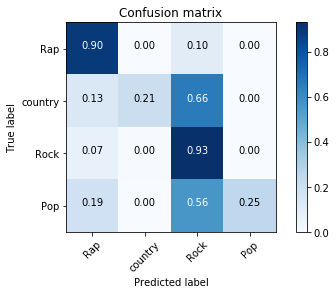

In [134]:
plt.show()

Confusion matrix, without normalization
[[189   0  22   0]
 [  7  11  35   0]
 [ 14   1 197   0]
 [  9   0  27  12]]


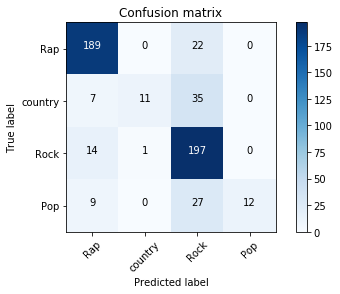

In [135]:
plot_confusion_matrix(confusion,['Rap', 'country', 'Rock', 'Pop'], normalize=False)
plt.show()

In [136]:
from sklearn.metrics import classification_report

In [150]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

In [139]:
ros = RandomOverSampler(random_state=0)

In [279]:
pipeline = Pipeline([('cv', CountVectorizer(stop_words='english')),
                     ('tfidf', TfidfTransformer()),
                     ('ros', RandomOverSampler(random_state=0)),
                     ('mnb', MultinomialNB(fit_prior=False)),
                    ])

parameters = {'cv__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False),
              'mnb__alpha': (1e-2, 1e-3)}
GridSearch = GridSearchCV(pipeline, parameters, n_jobs=-1)
GridSearch = GridSearch.fit(X_train, y_train)

results2 = GridSearch.predict(X_test)
np.mean(results2 == y_test)

0.85687022900763354

In [162]:
confusion = confusion_matrix(y_test, results, labels =['Rap', 'country', 'Rock', 'Pop'])

In [163]:
plot_confusion_matrix(confusion,['Rap', 'country', 'Rock', 'Pop'], normalize=True)

Normalized confusion matrix
[[ 0.96682464  0.          0.02843602  0.00473934]
 [ 0.13207547  0.60377358  0.26415094  0.        ]
 [ 0.0754717   0.02358491  0.87735849  0.02358491]
 [ 0.0625      0.04166667  0.3125      0.58333333]]


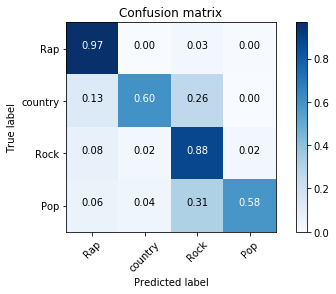

In [164]:
plt.show()

In [168]:
pipeline_svm = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                        ('ros', RandomOverSampler(random_state=0)),
                         ('svm', SGDClassifier(loss='hinge',alpha=1e-3, penalty='l2', max_iter=5, random_state=None))])

pipeline_svm = pipeline_svm.fit(X_train, y_train)
prediction_svm = pipeline_svm.predict(X_test)
np.mean(prediction_svm == y_test)

0.80916030534351147

In [170]:
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False),'svm__alpha': (1e-2, 1e-3)}
GridSearch = GridSearchCV(pipeline_svm, parameters_svm, n_jobs=-1)
GridSearch = GridSearch.fit(X_train, y_train)

prediction_svm = GridSearch.predict(X_test)
np.mean(prediction_svm == y_test)

0.85305343511450382

In [171]:
confusion = confusion_matrix(y_test, results, labels =['Rap', 'country', 'Rock', 'Pop'])

In [172]:
plot_confusion_matrix(confusion,['Rap', 'country', 'Rock', 'Pop'], normalize=True)

Normalized confusion matrix
[[ 0.96682464  0.          0.02843602  0.00473934]
 [ 0.13207547  0.60377358  0.26415094  0.        ]
 [ 0.0754717   0.02358491  0.87735849  0.02358491]
 [ 0.0625      0.04166667  0.3125      0.58333333]]


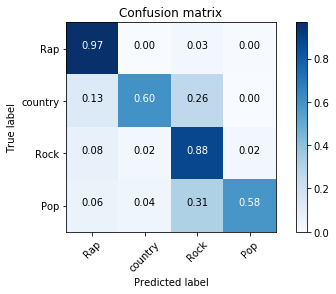

In [173]:
plt.show()

In [175]:
from wordcloud import WordCloud, STOPWORDS


In [179]:
wordcloud = WordCloud(
                        background_color='white',
                          stopwords=STOPWORDS,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(lyricData['Lyrics']))

In [182]:
fig = plt.figure(1)

In [183]:
plt.imshow(wordcloud)

In [184]:
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

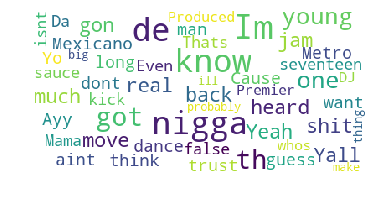

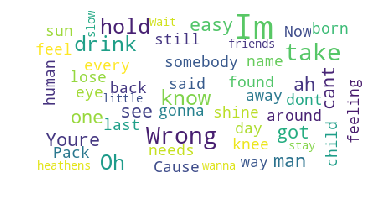

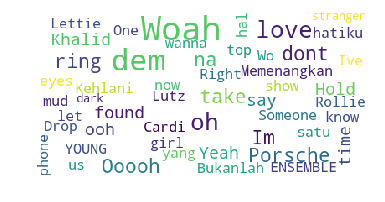

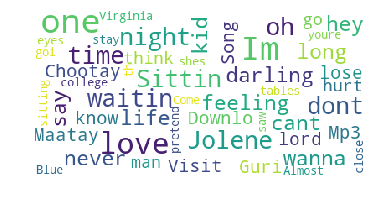

In [243]:
topWords = {}
for genre in lyricData['Genre'].unique():
    sliced = lyricData[lyricData['Genre'] == genre]
    wordcloud = WordCloud(
                        background_color='white',
                        collocations=False,
                          stopwords=STOPWORDS,
                          max_words=50,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(sliced['Lyrics']))
    fig = plt.figure(1)
    plt.imshow(wordcloud)
    topWords[genre] = wordcloud.words_
    plt.axis('off')
    plt.show()
    fig.savefig(genre + ".png", dpi=900)